In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Phase_Retrieval/classification_over_measurements/utils")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%tensorflow_version 2.x
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
import tensorflow_datasets as tfds
from LoadData import *
from AcquisitionLayer import Muestreo
from CallBacks import *
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from loss_and_metrics import *
from scipy.io import savemat, loadmat
import seaborn as sns

In [3]:
results_folder = os.path.join("..", "results", "fashion_mnist")
if not os.path.exists(results_folder):
  os.mkdir(results_folder)

In [4]:
SHAPE = (128,128)
BATCH_SIZE = 8
NUM_MEASUREMENTS = 1
NUM_CLASSES = 10
def preprocess(image,label, shape=SHAPE, NUM_CLASSES = NUM_CLASSES):
  x = image/255
  x = tf.image.resize(x, shape)
  mins = tf.math.reduce_min(x,axis=[1,2], keepdims=True)
  maxs = tf.math.reduce_max(x,axis=[1,2], keepdims=True)
  x = (x - mins)/(maxs-mins)
  x = x*0.7*np.pi
  x = tf.concat([tf.ones(tf.shape(x)), x], axis=-1)
  
  #label = tf.one_hot(label, 10, on_value=1, off_value=0, dtype=tf.int32)
  label = tf.one_hot(tf.cast(label, tf.int32), NUM_CLASSES)
  return x,label

In [5]:
train_images = tfds.load('fashion_mnist', split='train', as_supervised=True, batch_size=BATCH_SIZE)
test_images = tfds.load('fashion_mnist', split='test', as_supervised=True, batch_size=BATCH_SIZE)
train_images = train_images.map(preprocess)
test_images = test_images.map(preprocess)

In [6]:
x_train,y_train = list(train_images.take(1))[0]

In [7]:
def get_muestreo(modelo, x):
  for layer in modelo.layers:
    if layer.name == "noise":
      return layer(x, training=True)
    x = layer(x, training=True)

In [8]:
mobilnet = tf.keras.applications.MobileNetV2(input_shape=(*SHAPE,NUM_MEASUREMENTS), classes=NUM_CLASSES, weights=None, classifier_activation="softmax")

muestreo_layer = Muestreo(NUM_MEASUREMENTS, tipo_muestreo="ASM", sftf_folder=os.path.join("..", "SFTF_folder"), trainable=False)
input =  tf.keras.Input(shape=(*SHAPE,2), name='inputs')
x = muestreo_layer(input)
x = tf.keras.layers.GaussianNoise(0.01, name = "noise")(x)
x = mobilnet(x)
# for layer in mobilnet.layers:
#   x = layer(x)

modelo = tf.keras.Model(inputs=input, outputs=x)

# input =  tf.keras.Input(shape=(*SHAPE,2), name='inputs')
# x = muestreo_layer(input)
# modelo_muestreo = tf.keras.Model(inputs=input, outputs=x)
# muestreo_x = modelo_muestreo.predict(x_train)
muestreo_x = get_muestreo(modelo, x_train)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


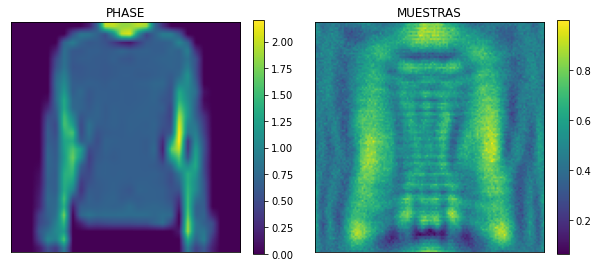

In [9]:
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(x_train[0,...,1]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
axs[0].set_title("PHASE")
a = axs[1].imshow(muestreo_x[0,...,0]); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[1],fraction=0.046)
axs[1].set_title("MUESTRAS")
fig.show()

In [10]:
modelo.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128, 128, 2)]     0         
_________________________________________________________________
Muestreo (Muestreo)          (None, 128, 128, 1)       0         
_________________________________________________________________
noise (GaussianNoise)        (None, 128, 128, 1)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 10)                2270218   
Total params: 2,270,218
Trainable params: 2,236,106
Non-trainable params: 34,112
_________________________________________________________________


In [11]:
chekpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(results_folder, "last_weights.h5"), save_weights_only=True)
opti = tf.keras.optimizers.Adam(amsgrad=True, learning_rate=5e-4)
modelo.load_weights(os.path.join(results_folder, "last_weights.h5"))
modelo.save_weights(os.path.join(results_folder, "initial_weights.h5"))
modelo.compile(optimizer='adam', loss = "binary_crossentropy", metrics="accuracy")
history = modelo.fit(train_images, epochs=100,validation_data=test_images, callbacks=[chekpoint])

Epoch 1/100
7500/7500 [==============================] - 228s 30ms/step - loss: 0.0133 - accuracy: 0.9765 - val_loss: 0.0786 - val_accuracy: 0.9044
Epoch 2/100
7500/7500 [==============================] - 217s 29ms/step - loss: 0.0119 - accuracy: 0.9792 - val_loss: 0.0896 - val_accuracy: 0.8957
Epoch 3/100
7500/7500 [==============================] - 216s 29ms/step - loss: 0.0116 - accuracy: 0.9800 - val_loss: 0.0901 - val_accuracy: 0.8982
Epoch 4/100
7500/7500 [==============================] - 222s 30ms/step - loss: 0.0112 - accuracy: 0.9807 - val_loss: 0.0791 - val_accuracy: 0.9025
Epoch 5/100
7500/7500 [==============================] - 219s 29ms/step - loss: 0.0107 - accuracy: 0.9815 - val_loss: 0.0860 - val_accuracy: 0.9004
Epoch 6/100
7500/7500 [==============================] - 212s 28ms/step - loss: 0.0099 - accuracy: 0.9837 - val_loss: 0.0935 - val_accuracy: 0.8971
Epoch 7/100
7500/7500 [==============================] - 212s 28ms/step - loss: 0.0099 - accuracy: 0.9830 - val_

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
modelo.load_weights(os.path.join(results_folder, "last_weights.h5"))

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(x_train[0,...,1]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
axs[0].set_title("PHASE")
a = axs[1].imshow(muestreo_x[0,...,0]); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[1],fraction=0.046)
axs[1].set_title("MUESTRAS")
fig.show()

In [ ]:
muestreo_x = get_muestreo(modelo, x_train)

In [ ]:
pred_labels = np.array([])
real_labels = np.array([])
for image, label in test_images:
  label_pred = tf.argmax(modelo.predict(image),axis=1).numpy()
  label = tf.argmax(label,axis=1).numpy()
  pred_labels = np.concatenate((label_pred,pred_labels),axis=0)
  real_labels = np.concatenate((label,real_labels),axis=0)

In [ ]:
cf_matrix = tf.math.confusion_matrix(real_labels, pred_labels, num_classes=100)
cf_matrix = cf_matrix/np.sum(cf_matrix, axis=1)[:, np.newaxis]
plt.figure(figsize=(12,9))
sns.heatmap(cf_matrix, annot=True, vmin=0)
plt.savefig(os.path.join(results_folder, "confusion_matrix.svg"))